In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [9]:
## Load dataset
columns = ['target','ids','date','flag','user','text']
data=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO_8859_1',names=columns)


In [11]:
##Aperçu des données
data.sample(5)

,target,ids,date,flag,user,text
404905,0,2058539932,Sat Jun 06 15:08:34 PDT 2009,NO_QUERY,zoevivi,@z_mealor awh really? i'm well gutted i misse...
479309,0,2178828064,Mon Jun 15 08:15:42 PDT 2009,NO_QUERY,Knoxafur,Shit!!!! Just remembered that I haven`t finish...
30400,0,1563755481,Mon Apr 20 00:07:27 PDT 2009,NO_QUERY,Dimera666,"@Melisa_Swenson whatevz, I was totally sitting..."
145994,0,1882365119,Fri May 22 06:44:25 PDT 2009,NO_QUERY,acummings,@overheardatmoo - How come a discount for NEW ...
1278047,4,2001385295,Tue Jun 02 00:42:48 PDT 2009,NO_QUERY,felicia_k,"@Kegs1528 thanks i'm working for them, mostly..."


In [12]:
data.shape

(1600000, 6)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [14]:
data.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [15]:
data.duplicated().sum()

np.int64(0)

In [16]:
##verification de l'unicité des valeurs dans la colonne target
data['target'].unique()

array([0, 4])

In [17]:
##remplacon 4 par 1 pour la colonne target
data['target']=data['target'].replace(4,1)

In [18]:
##Analyse descriptive
data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [19]:
##conversion de la variable date en type datetime
data['date']=pd.to_datetime(data['date'])

C:\Users\ABDILLAHIOMARDJAMA\AppData\Local\Temp\ipykernel_54184\733024155.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date']=pd.to_datetime(data['date'])


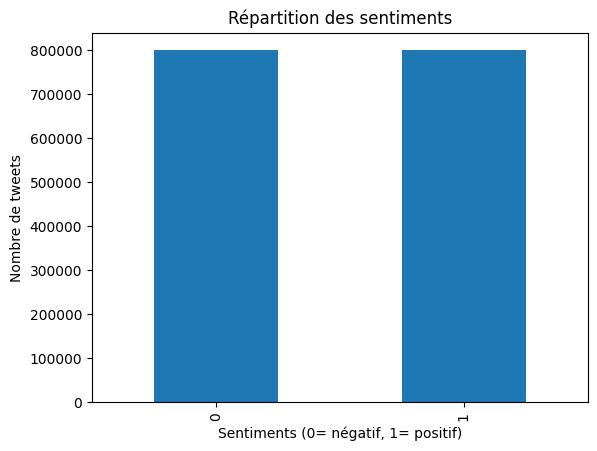

In [20]:
##faison une analyse visuelle des sentiments
data['target'].value_counts().plot(kind='bar')
plt.title('Répartition des sentiments')
plt.xlabel('Sentiments (0= négatif, 1= positif)')
plt.ylabel('Nombre de tweets')
plt.show()

In [21]:
##Nous allons essayer de dimunier le nombre de données pour faciliter le traitement,on va selection 10000 tweets positifs et 10000 tweets négatifs
data_positive=data[data['target']==1].sample(10000,random_state=42)
data_negative=data[data['target']==0].sample(10000,random_state=42)
data_balanced=pd.concat([data_positive,data_negative])

In [22]:
data_balanced['target'].value_counts()

target
1    10000
0    10000
Name: count, dtype: int64

In [29]:
##affichons un aperçu des données aleatoires,juste la variable target et text
data_balanced[['target', 'text']].sample(10)

,target,text
842553,1,AGHHHH !!!! hate school i can't wait for SUMME...
25967,0,one more day of vacation
1133158,1,@saronti Just wait until I find a pic of an ol...
823709,1,Phantom Hourglass Manga: Now in English http:/...
1177578,1,@taylorswift13 &quot;I just impulsively bought...
723818,0,Probably my favorite thing about lbk is how ma...
1130097,1,i hope the cavs make it to the finals...so the...
730761,0,Just looked at the top 4 some strange reason.....
1079188,1,"Oh yeaaa lakers gonna win it this year, Kobe h..."
924383,1,HAPPY MOTHERS DAY


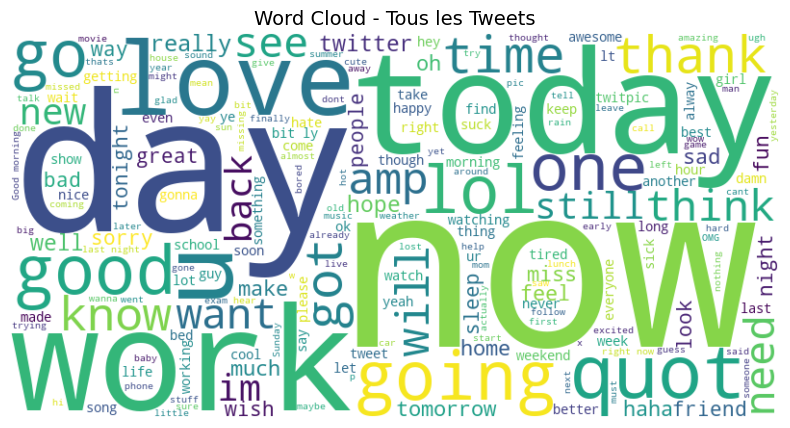

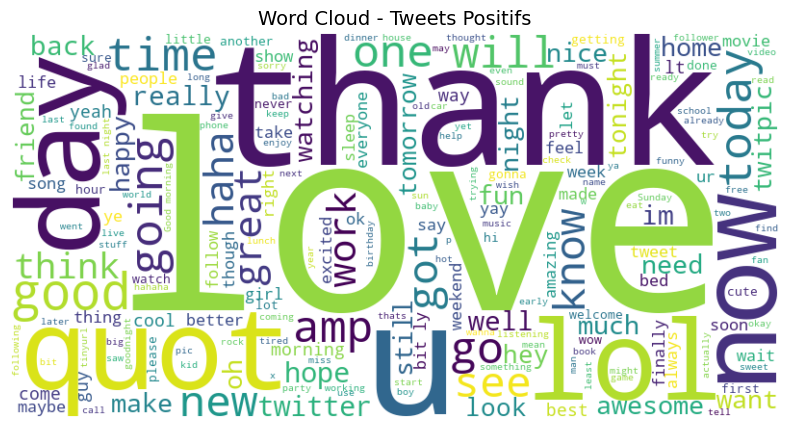

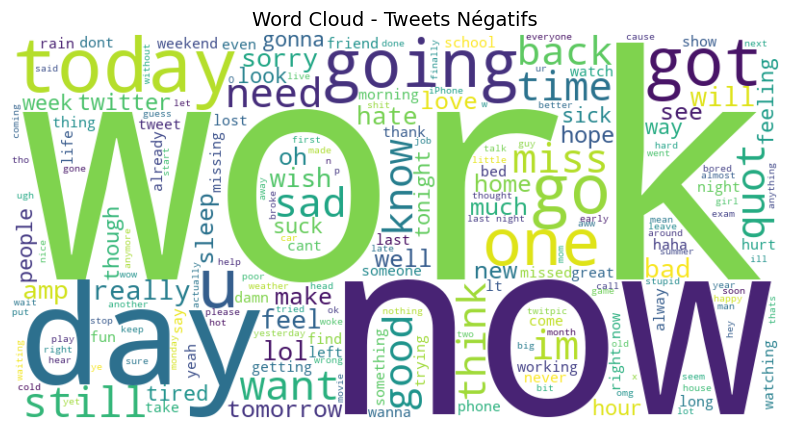

In [98]:
##faison le  wordcloud pour les tweets positifs et négatifs,il va nous aider à visualiser les mots les plus fréquents dans chaque catégorie de sentiment.
# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

##genérons le wordcloud pour tout les tweets après le pretraitement
generer_wordcloud(data_balanced['text'], 'Word Cloud - Tous les Tweets')
# Générer le word cloud pour les tweets positifs
generer_wordcloud(data_balanced[data_balanced['target']==1]['text'], 'Word Cloud - Tweets Positifs')

# Générer le word cloud pour les tweets négatifs
generer_wordcloud(data_balanced[data_balanced['target']==0]['text'], 'Word Cloud - Tweets Négatifs')


Prétraitement des tweets

Tokenisation :La tokenisation consiste à diviser un texte en unités linguistiques plus petites appelées "tokens". Un token peut être un mot individuel, une ponctuation ou même une partie d'un mot, selon la façon dont le texte est analysé. La tokenisation est souvent réalisée en utilisant des techniques telles que la séparation par des espaces, la reconnaissance de motifs (regex) ou l'utilisation de modèles de langage.

In [60]:
###Commencon maitennat la pretraitement des données textuelles
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from pathlib import Path

from pathlib import Path
venv_data_path = Path(r"C:\Users\ABDILLAHIOMARDJAMA\Documents\Projet_churn\venv\nltk_data")
venv_data_path.mkdir(parents=True, exist_ok=True)

# Téléchargement local
nltk.download('punkt', download_dir=venv_data_path, quiet=True)
nltk.download('punkt_tab', download_dir=venv_data_path, quiet=True)
nltk.download('stopwords', download_dir=venv_data_path, quiet=True)
nltk.download('wordnet', download_dir=venv_data_path, quiet=True)
nltk.download('omw-1.4', download_dir=venv_data_path, quiet=True)
nltk.download('averaged_perceptron_tagger', download_dir=venv_data_path, quiet=True)
nltk.download('averaged_perceptron_tagger_eng', download_dir=venv_data_path, quiet=True)


# Ajout du chemin au PATH NLTK
nltk.data.path.append(str(venv_data_path))
# --- utilitaires ---
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
lemmatizer = WordNetLemmatizer()

# Stop-words anglais, mais on conserve negations & intensifs
stop_words = set(stopwords.words("english"))
protected = {"not", "no", "nor", "never", "too", "very", "so", "ain", "aren", "couldn", "didn",
             "doesn", "hadn", "hasn", "haven", "isn", "mightn", "mustn", "needn",
             "shan", "shouldn", "wasn", "weren", "won", "wouldn"}  # variantes de n't en NLTK
stop_words = stop_words.difference(protected)

# Map POS NLTK -> WordNet
def _to_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # défaut raisonnable

# Normalisation d’allongements (looooove -> loove)
_re_elong = re.compile(r"(.)\1{2,}", re.UNICODE)
def _reduce_elongations(token, keep=2):
    return _re_elong.sub(lambda m: m.group(1) * keep, token)

# Remplacer URLs / mentions / hashtags
_re_url = re.compile(r"http\S+|www\.\S+")
_re_user = re.compile(r"@\w+")
_re_hashtag = re.compile(r"#(\w+)")  # garde le mot, retire juste '#'

def normalize_specials(text):
    text = _re_url.sub("httpurl", text)
    # Remplace les mentions par jeton @user (pour garder le signal social)
    text = _re_user.sub("@user", text)
    # Option 1: enlever '#'
    text = _re_hashtag.sub(r"\1", text)
    # Option 2 (si tu veux garder le signal hashtag): text = re.sub(r"#(\w+)", r"hashtag_\1", text)
    return text

# Expansion minimale de contractions clés (sans package externe)
_contractions = {
    "can't": "can not", "won't": "will not", "don't": "do not", "doesn't": "does not",
    "didn't": "did not", "isn't": "is not", "aren't": "are not", "wasn't": "was not",
    "weren't": "were not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "shouldn't": "should not", "wouldn't": "would not", "couldn't": "could not",
    "i'm": "i am", "i’ve": "i have", "i'd": "i would", "i'll": "i will",
    "it's": "it is", "that's": "that is", "there's": "there is", "what's": "what is",
    "you're": "you are", "we're": "we are", "they're": "they are",
    "he's": "he is", "she's": "she is", "who's": "who is",
    "couldn't've": "could not have", "shouldn't've": "should not have", "wouldn't've": "would not have"
}
_re_contr = re.compile(r"\b(" + "|".join(map(re.escape, _contractions.keys())) + r")\b")

def expand_contractions(text):
    return _re_contr.sub(lambda m: _contractions[m.group(0)], text)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # 1) Lower & expansions
    text = text.lower().strip()
    text = expand_contractions(text)

    # 2) Normaliser URLs/mentions/hashtags
    text = normalize_specials(text)

    # 3) Tokeniser (spécial Twitter, garde les emojis, réduit les looong)
    tokens = tknzr.tokenize(text)

    # 4) Réduire les allongements
    tokens = [_reduce_elongations(tok) for tok in tokens]

    # 5) Enlever la ponctuation isolée sauf '@user' et 'httpurl'
    tokens = [t for t in tokens if (t.isalnum() or t in {"@user", "httpurl"})]

    # 6) Stop-words (en protégeant negations & intensifs déjà exclus)
    tokens = [t for t in tokens if t not in stop_words]

    # 7) POS tagging -> lemmatisation
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(w, _to_wordnet_pos(p)) for w, p in tagged]

    # 8) Join final
    return " ".join(lemmas)

In [61]:
data_balanced['cleaned_text'] = data_balanced['text'].apply(clean_tweet)

In [79]:
data_balanced[['text', 'cleaned_text']].sample(5)

,text,cleaned_text
1404541,Movie day,movie day
1243588,@I_am_Heather Awesome Well have fun in NZ!,@user awesome well fun nz
409620,@just_J_ i love bobby longs music ! Although i...,@user love bobby longs music although not find...
1291184,@dakronick seru bgt rame&quot;!! Enjoy then. H...,@user seru bgt rame enjoy hahhaha go enjoy hah...
1444243,Strutin right along to Mansion now!,strutin right along mansion


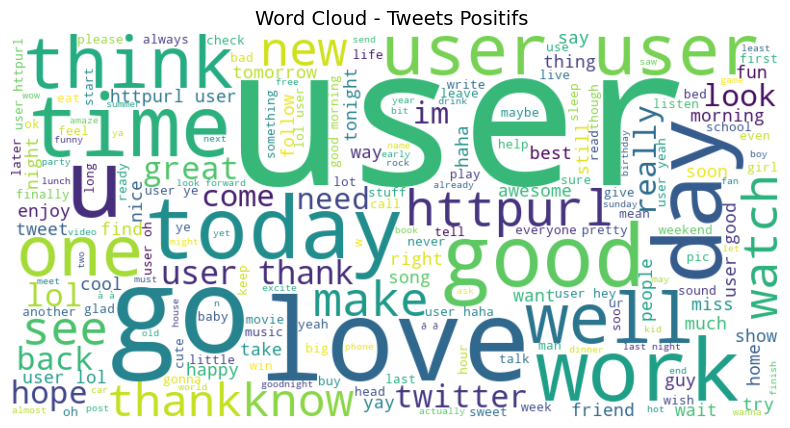

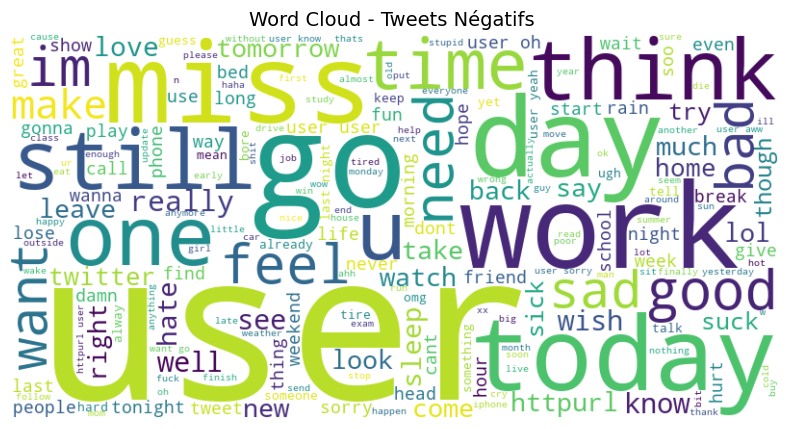

In [80]:
##generons le wordcloud après le pretraitement
generer_wordcloud(data_balanced[data_balanced['target']==1]['cleaned_text'], 'Word Cloud - Tweets Positifs ')
generer_wordcloud(data_balanced[data_balanced['target']==0]['cleaned_text'], 'Word Cloud - Tweets Négatifs ')

Convertir le texte en numérique

TF-IDF (Term Frequency-Inverse Document Frequency)
TF-IDF est une technique utilisée en traitement automatique du langage naturel (NLP) pour évaluer l'importance d'un terme dans un document par rapport à une collection de documents. Elle combine la fréquence du terme (TF) et l'inverse de la fréquence dans les documents (IDF).

TF mesure le nombre de fois qu'un terme apparaît dans un document, tandis que IDF évalue l'importance d'un terme dans la collection globale de documents en réduisant le poids des termes fréquents.

En utilisant TF-IDF, on peut attribuer une valeur numérique à chaque terme, reflétant à la fois sa fréquence dans le document et son importance relative dans la collection de documents.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'texte_nettoye'
features = vectorizer.fit_transform(data_balanced['cleaned_text'])

# Convertir les caractéristiques en une représentation de matrice creuse
features = features.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)


Dimensions de la matrice de caractéristiques : (20000, 17360)


Modelisation

In [91]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, data_balanced['target'], test_size=0.2, stratify=data_balanced['target'], random_state=42)

In [92]:
# Construire le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [93]:
# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

In [94]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

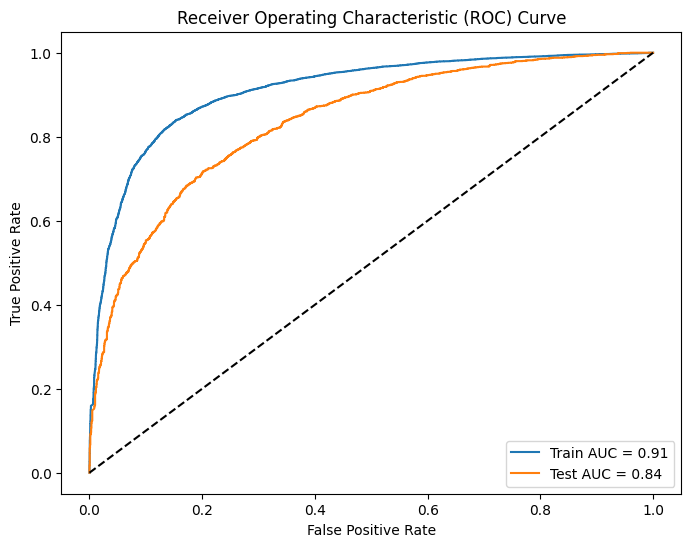

In [95]:

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [96]:
# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, model.predict(X_train))
train_precision = precision_score(y_train, model.predict(X_train))
train_recall = recall_score(y_train, model.predict(X_train))
train_f1 = f1_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
test_precision = precision_score(y_test, model.predict(X_test))
test_recall = recall_score(y_test, model.predict(X_test))
test_f1 = f1_score(y_test, model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)

  Performance     Train      Test
0    Accuracy  0.840500  0.753250
1   Precision  0.836546  0.747677
2      Recall  0.846375  0.764500
3    F1 Score  0.841432  0.755995


In [97]:
import joblib

joblib.dump(model, "model.joblib")
joblib.dump(vectorizer, "vectorizer.joblib")


['vectorizer.joblib']